# 자동차 번호판 인식 with OpenCV

In [2]:
'''! pip install ultralytics opencv-python pytesseract
! apt-get install -y tesseract-ocr

# Python용 pytesseract 라이브러리 설치
! pip install pytesseract
! pip install opencv-python-headless

! apt-get install -y tesseract-ocr-kor

!pip install opencv-python
!pip install matplotlib

# yolo v5 clone
! git clone https://github.com/ultralytics/yolov5
! pip install -r yolov5/requirements.txt'''

'! pip install ultralytics opencv-python pytesseract\n! apt-get install -y tesseract-ocr\n\n# Python용 pytesseract 라이브러리 설치\n! pip install pytesseract\n! pip install opencv-python-headless\n\n! apt-get install -y tesseract-ocr-kor\n\n!pip install opencv-python\n!pip install matplotlib\n\n# yolo v5 clone\n! git clone https://github.com/ultralytics/yolov5\n! pip install -r yolov5/requirements.txt'

## 1. 라이브러리 호출

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'   #기기에 설치된 소프트웨어적인 문제로 인한 임시조치
import cv2
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
#import pathlib                              ########################################
#temp = pathlib.PosixPath                    #  리눅스에서 작성된 파일을 윈도우에서 사용  #
#pathlib.PosixPath = pathlib.WindowsPath     ########################################
#pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe' # windows
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'                  # linux

## 2. Read Input Image

HBOS3/runs/detect/result/crops/license_plate/KakaoTalk_20241202_154925187.jpg
640 640 1


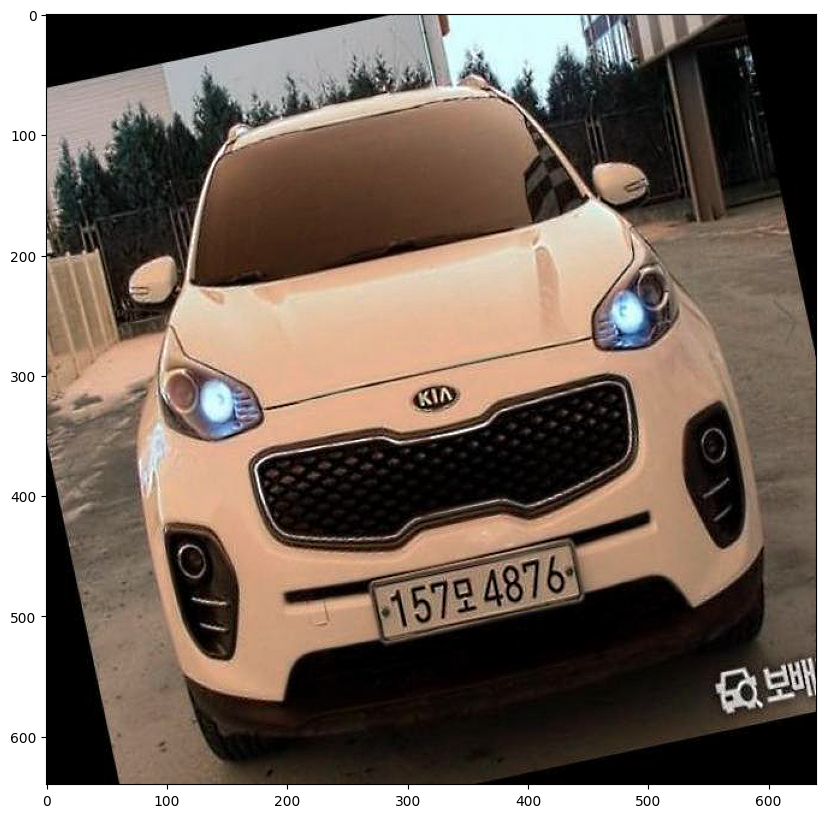

In [ ]:
"""
- 특정 폴더 내에 있는 "가장 최근에 생성된" 파일을 리턴 
"""
folder_path = 'yolov5/runs/detect/result/crops/license_plate/'  # 번호판을 크롭, 저장한 폴더의 경로

# each_file_path_and_gen_time: 각 file의 경로와, 생성 시간을 저장함
each_file_path_and_gen_time = []
for each_file_name in os.listdir(folder_path):
    # getctime: 입력받은 경로에 대한 생성 시간을 리턴
    each_file_path = folder_path + each_file_name
    each_file_gen_time = os.path.getctime(each_file_path)
    each_file_path_and_gen_time.append(
        (each_file_path, each_file_gen_time)
    )

# 가장 생성시각이 큰(가장 최근인) 파일을 리턴 

'''수업 내용인 First-Class Functions 중 Anonymous Functions을 활용해 익명함수 생성'''
most_recent_file = max(each_file_path_and_gen_time, key=lambda x: x[1])[0]  #가장 최근에 찍힌 번호판 이미지
print(most_recent_file) # 이미지 이름 출력
img_ori = cv2.imread(most_recent_file)      #most_recent_file     <-이미지파일일




height, width, channel = img_ori.shape
channel = 1

# Morphology Operation
StructuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
topHat = cv2.morphologyEx(img_ori, cv2.MORPH_TOPHAT, StructuringElement)
blackHat = cv2.morphologyEx(img_ori, cv2.MORPH_BLACKHAT, StructuringElement)
img_topHat = cv2.add(img_ori, topHat)
img_ori = cv2.subtract(img_topHat, blackHat)
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
# Gaussian Blurring
blur = cv2.GaussianBlur(gray, (5, 5), 2)

# Adaptive Thresholding
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
img_blurred,
maxValue=255.0,
adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
thresholdType=cv2.THRESH_BINARY_INV,
blockSize=19,
C=9
)
plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')
print(height, width, channel)


## 3. Convert Image to Grayscale

* BGR -> GRAY 변환법
1. BGR2GRAY
```python
cv2.cvtColor(이미지, cv2.COLOR_BGR2GRAY)
```
2. hsv
```python
hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
gray = hsv[:, :, 2]
```

In [ ]:
def img_to_gray(img_ori, image_show=True):
    gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)     
    if image_show:
        plt.figure(figsize=(7,5))
        plt.imshow(gray, cmap='gray')
        plt.title('흑백화')
    return gray

## 4. Adaptive Thresholding

* GaussianBlur  
: 노이즈를 줄이기 위해  
  
* adaptiveThreshold  
: threshold 보다 낮은 값 = 0, 높은 값 : 255  
: 이미지 구분을 쉽게 만들어줌  

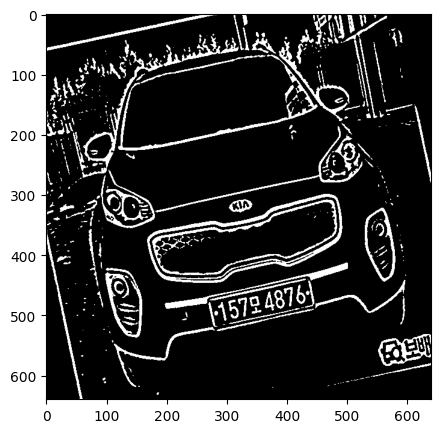

In [9]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=11
)
plt.figure(figsize=(8,5))
plt.imshow(img_blur_thresh, cmap='gray')

## 5. Find Contours

이미지에서 윤곽선 찾기  

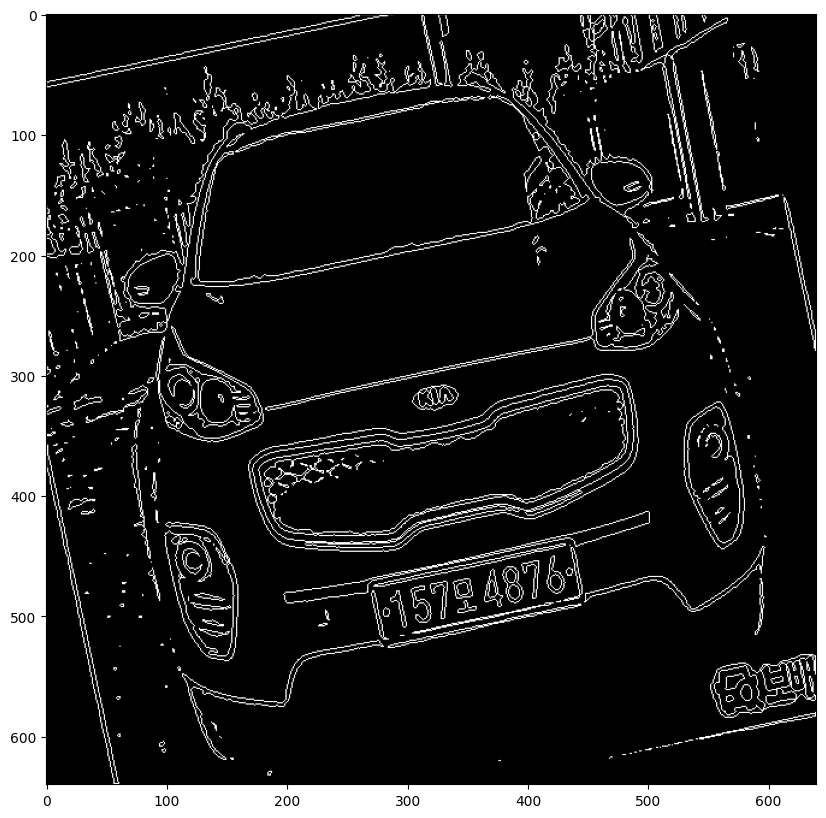

In [ ]:
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8) 

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 6. Prepare Data

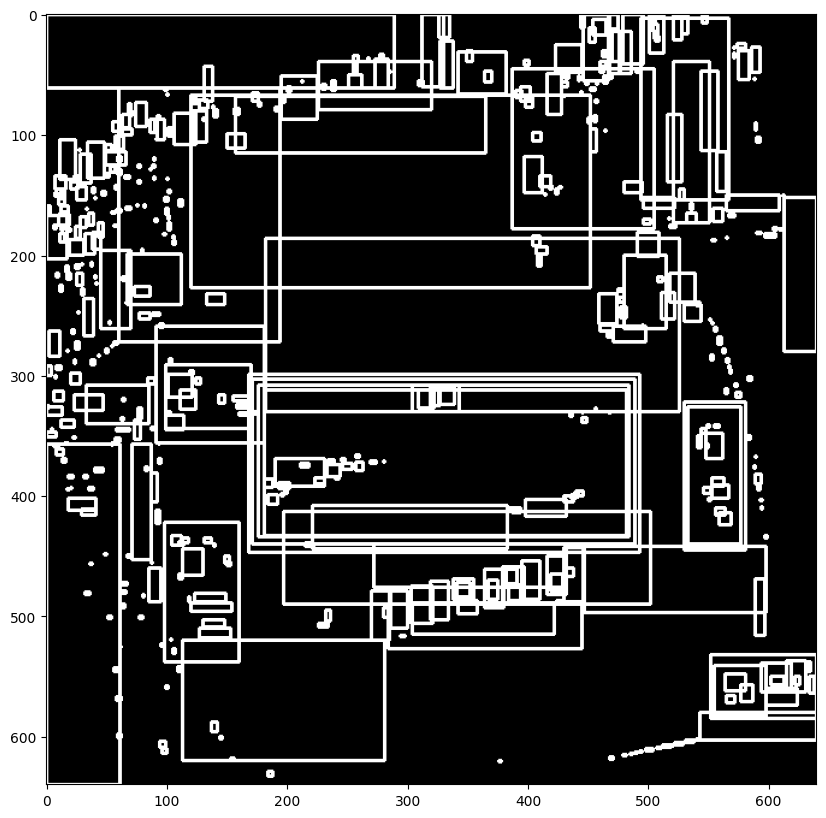

In [ ]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')
    

## 7. Select Candidates by Char Size

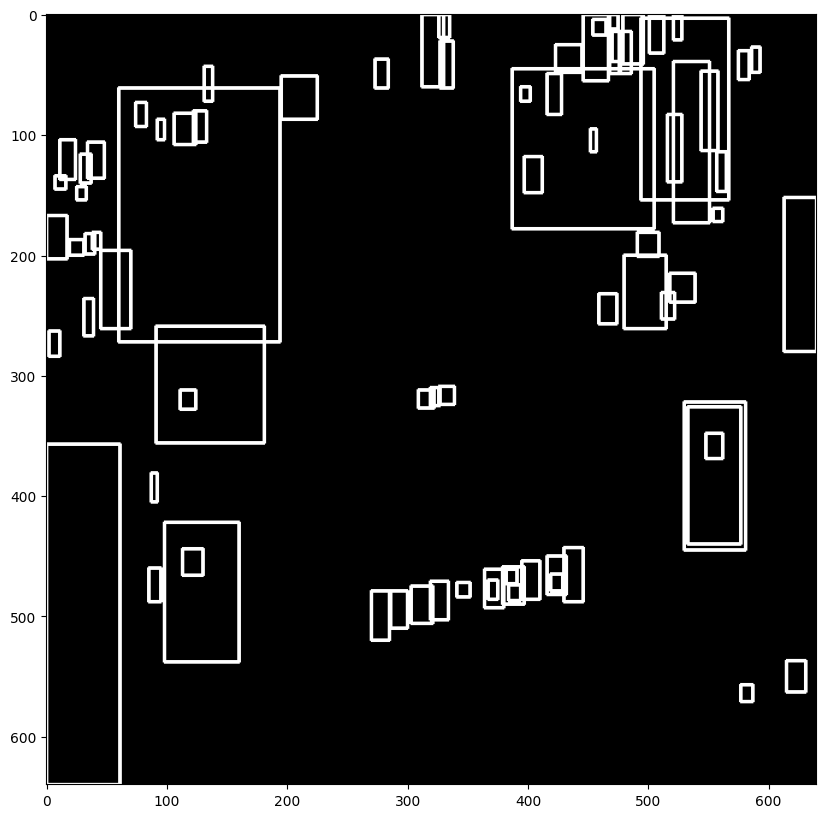

In [ ]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.2, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 8. Select Candidates by Arrangement of Contours

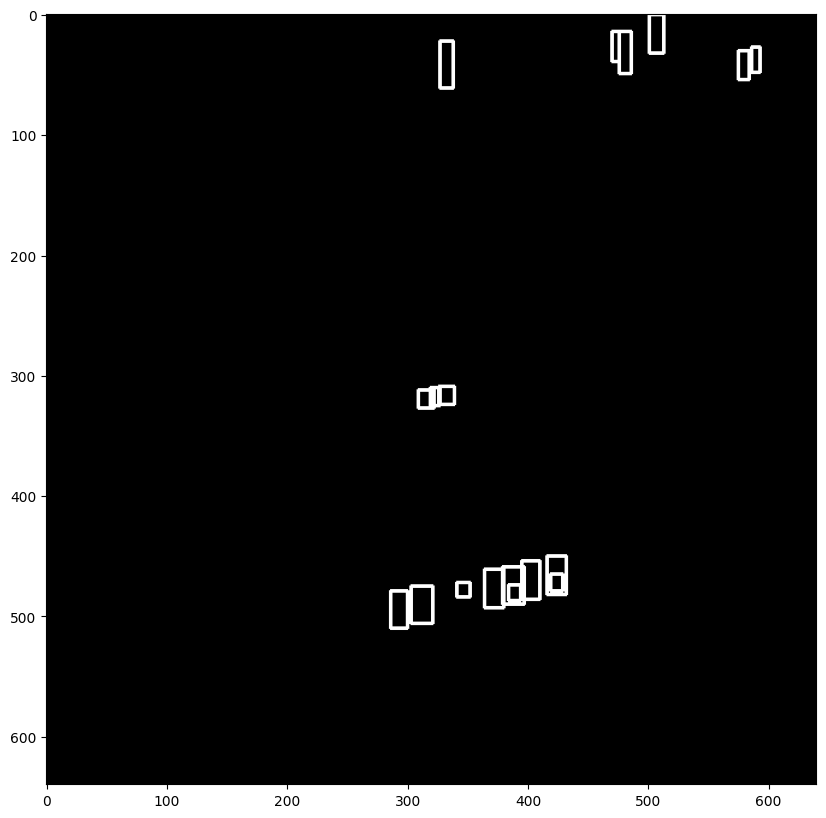

In [ ]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## 9. Rotate Plate Images

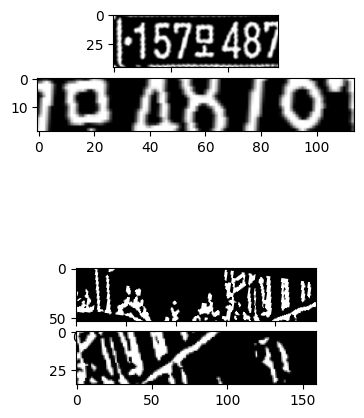

In [ ]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):


    '''수업 내용인 First-Class Functions 중 Anonymous Functions을 활용해 익명함수 생성'''
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])     # 익명함수 생성

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_blur_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

## 10. Another Thresholding

## 11. Find Chars   확인 필요

157모487
조머나해




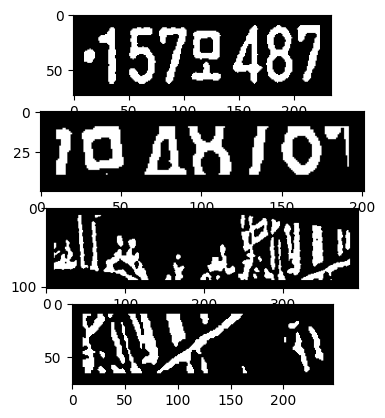

In [ ]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    chars = pytesseract.image_to_string(img_result, lang='kornum+kor', config='--psm 6 preserve_interword_spaces')
    #chars = pytesseract.image_to_string(img_result, lang='kornum+kor', config='--psm 7 --oem 3')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

## 12. Result

인식이 되지 않았습니다 재진입하십시오


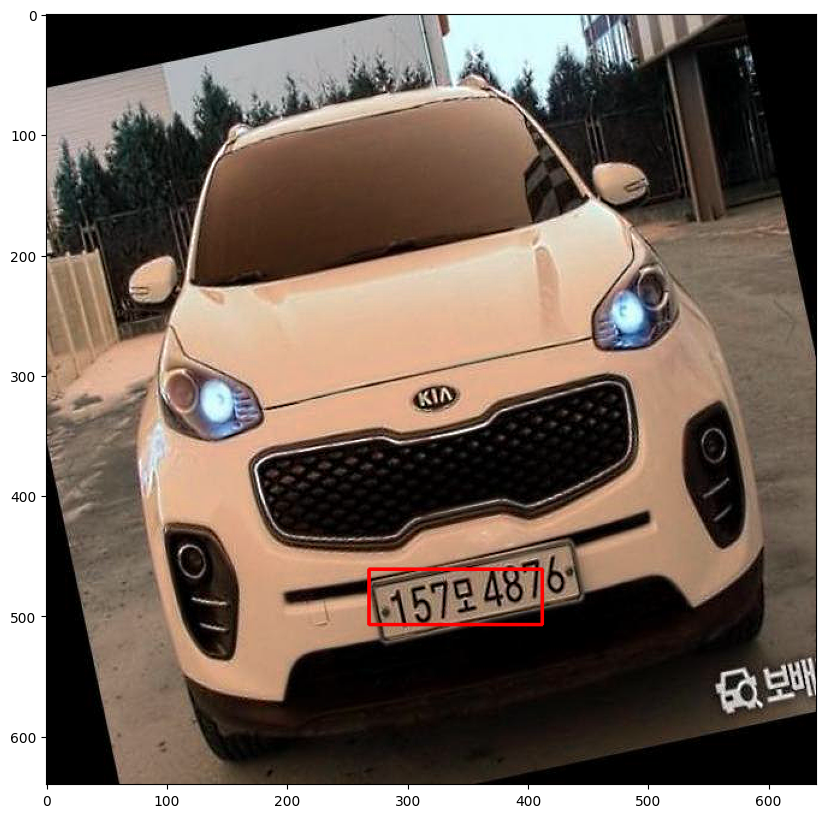

In [ ]:
try :
    info = plate_infos[longest_idx]
    chars = plate_chars[longest_idx]
    if ord('가') <= ord(chars[2]) <= ord('힣') and len(chars) == 7:
        print(chars)
        #excel()
    elif ord('가') <= ord(chars[3]) <= ord('힣') and len(chars) == 8:
        print(chars)
        #excel()
    else :
        print('인식이 되지 않았습니다 재진입하십시오')

    img_out = img_ori.copy()

    cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

    cv2.imwrite(chars + '.jpg', img_out)

    plt.figure(figsize=(12, 10))
    plt.imshow(img_out)
except :
    print()
    

In [ ]:
'''
df = pd.read_excel('plates.xlsx', sheet_name='Sheet1')
row_list = []

df.loc[len(df)] = [chars]
# Excel 파일로 저장
df.to_excel('plates.xlsx', index=False, sheet_name='Sheet1')

df.info
'''

"\ndf = pd.read_excel('plates.xlsx', sheet_name='Sheet1')\nrow_list = []\n\ndf.loc[len(df)] = [chars]\n# Excel 파일로 저장\ndf.to_excel('plates.xlsx', index=False, sheet_name='Sheet1')\n\ndf.info\n"